# A Multiclass Face Recognition CNN Model
## Shengping Jiang
This model is built upon on keras and OpenCV. It can be trained with certain image data structure. It counts classes automatically and converts class name to a binary label array. It illustrates training accuracy vs epochs.   

In [1]:
# This is a face recognition CNN model and training program
# This notebook is used to traing more than two classes-2020.11.13
# Shengping Jiang

import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import cv2
import random
from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K

np.random.seed(1)

Using TensorFlow backend.


In [2]:
# This function resizes an image to given height x width. 
# We prefer to resize all images to a square (height = width)

def resize_image(image, height, width):
    top, bottom, left, right = (0, 0, 0, 0)
    
    #获取图像尺寸
    h, w, _ = image.shape
    
    #对于长宽不相等的图片，找到最长的一边
    longest_edge = max(h, w)    
    
    #计算短边需要增加多上像素宽度使其与长边等长
    if h < longest_edge:
        dh = longest_edge - h
        top = dh // 2
        bottom = dh - top
    elif w < longest_edge:
        dw = longest_edge - w
        left = dw // 2
        right = dw - left
    else:
        pass 
    
    #RGB颜色
    BLACK = [0, 0, 0]
    
    #给图像增加边界，是图片长、宽等长，cv2.BORDER_CONSTANT指定边界颜色由value指定
    constant = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_CONSTANT, value = BLACK)
    
    #调整图像大小并返回
    return cv2.resize(constant, (height, width))

## Image data structure
Put image data as a folder structure below. Please note: classname or image name are not necessary with a number<br>

--data<br>
&nbsp;&nbsp;&nbsp;&nbsp;|--train<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--classname0<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--classname1<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--classnameN<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--image0.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--image1.jpg<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--imageM.jpg<br>
<br>

## The function load_data() prepares training and validation images
* Only searches images files with a structure as above<br>
* Reads an image as numpy format<br>
* Resizes an image by calling resize_image()<br>
* Adds an image to a list images. Convert the images list to numpy format images<br>
* Normanizes image data from range 0-255 to range 0-1, and make data as float<br>
* Extracts classname and put in a list labels<br>
* Converts string list labels to a binary list (numpy format) as below:<br>
caojun --> [1 0 0 0] <br>
chenshu --> [0 1 0 0]<br>
gujiacheng --> [0 0 1 0]<br>
mengziyi --> [0 0 0 1]<br>
Note: the conversion will be done in alphabet order of classname automatically. Above is an example of four classes. For more classes, the binary value will be extended <br>
* Converts binary data from integer to float: ex. [0 0 1 0] -->[0. 0. 1. 0.]<br>
* Creates a dictionary output by mapping a number with a classname in alphabet order as below: <br>
{0:'caojun',1:'chenshu',2:'gujiacheng',3:'mengziyi'} <br>
The dictionary output will be used by prediction (this is an example of four classes)<br> 

In [3]:
# Process images before loading 
extension = ['jpg','png','bmp','jpeg']
def load_data(path_name, img_rows, img_cols): 
    images = []
    labels = []
    class_names = []
    for (root,dirs,files) in os.walk(path_name):
        #print('root:',root)
        pattern = '^\w+/train/'
        if re.match(pattern, root):
            print('root:',root)
            #print('files:',files)
            #label = root.split('/')[-1]
            for img in files:
                img = img.lower()
                if img.split('.')[1] in extension:
                    full_path = os.path.join(root, img)
                    #print('full_path:',full_path)
                    image = cv2.imread(full_path)                
                    #print('image.shape, img_rows, img_cols:', image.shape, img_rows, img_cols)
                    image = resize_image(image, img_rows, img_cols)
                    #print('image.shape2:',image.shape)
                    label = full_path.split('/')[-2]
                    # Add image and label to images and lanels
                    images.append(image)                
                    labels.append(label)
        else:   #no train folder
            print("Root folder:",root)
            #break
    # Converting images to numpy. Convert class name to binary value
    images = np.array(images)
    #像素数据浮点化及归一化(图像的各像素值归一化到0~1区间)
    images = images.astype('float32')
    images /= 255
    
    # This will get how many names in the labels (nb_classes)
    class_names = pd.get_dummies(labels).columns
    nb_classes = len(pd.get_dummies(labels).columns)
    
    # Create a name dictionary for prediction 
    output = {}
    for i in range(len(class_names)):
        output[i] = class_names[i]
    # Convert class name to binary value
    labels = pd.get_dummies(labels).values
    # change binary values to float from integer
    labels = labels.astype('float32')   
    print('image size2:', len(images))
    return images,labels, nb_classes, output



In [4]:
# Example of pd.get_dummies()
names =['Caojun','Shengping','Shengping','Gujiacheng','Mengziyi','Chenshu','Chenshu']
bivalue = pd.get_dummies(names).columns
print(type(bivalue))
print(bivalue)

<class 'pandas.core.indexes.base.Index'>
Index(['Caojun', 'Chenshu', 'Gujiacheng', 'Mengziyi', 'Shengping'], dtype='object')


In [5]:
#Prepare training and validation data (准备训练与验证数据)
train_path = 'data'
IMAGE_SIZE = 64
images, labels, nb_classes, output = load_data(train_path, img_rows = IMAGE_SIZE, img_cols = IMAGE_SIZE)
# Separate images and labels to training group and validation group
train_images, valid_images, train_labels, valid_labels \
             = train_test_split(images, labels, test_size = 0.2, random_state = random.randint(0, 100))        

Root folder: data
Root folder: data/train
root: data/train/mengziyi
root: data/train/caojun
root: data/train/chenshu
root: data/train/gujiacheng
image size2: 76


In [6]:
print('train_images.shape:',train_images.shape)
print(type(train_images))
print("train_images[0].shape:",train_images[0].shape)
print("type of train_labels:",type(train_labels))
print("type of train_labels element:",type(train_labels[0]))
print("nb_classes:",nb_classes)
print("output:",output)

train_images.shape: (60, 64, 64, 3)
<class 'numpy.ndarray'>
train_images[0].shape: (64, 64, 3)
type of train_labels: <class 'numpy.ndarray'>
type of train_labels element: <class 'numpy.ndarray'>
nb_classes: 4
output: {0: 'caojun', 1: 'chenshu', 2: 'gujiacheng', 3: 'mengziyi'}


In [7]:
# Processing testing data. This cell is for processing separated test images
# -> appending images in a list 'test_images'
# -> appending labels in a list 'test_labels'
# The test data contains labels as well also we are appending it to a list but we are'nt going to use it while training.

#test_images = []
#test_labels = []
#shape = (64,64)
#test_path = 'data/test'

#for filename in os.listdir('data/test'):
#    if filename.split('.')[1] == 'jpg':
#        img = cv2.imread(os.path.join(test_path,filename))
        
        # Spliting file names and storing the labels for image in list
#        test_labels.append(filename.split('_')[0])
        
        # Resize all images to a specific shape
#        img = cv2.resize(img,shape)
        
#        test_images.append(img)
        
# Converting test_images to array
#test_images = np.array(test_images)

You can see the training images are distortion. This is because we resized images smmaller than original size.

[0. 0. 0. 1.]


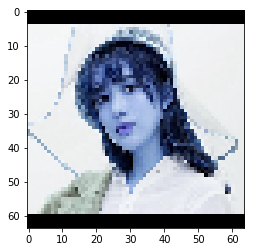

In [8]:
# Visualizing Training data
print(train_labels[1])
plt.imshow(train_images[1])

[0. 1. 0. 0.]


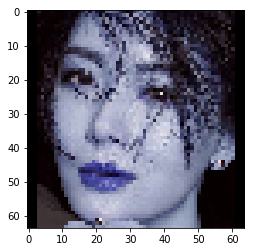

In [9]:
# Visualizing Training data
print(valid_labels[15])
plt.imshow(valid_images[15])

In [10]:
#Build a CNN model by add convolution, MaxPool2D, Dropout, Flatten, Dense layers
#构建一个空的网络模型，它是一个线性堆叠模型，各神经网络层会被顺序添加，专业名称为序贯模型或线性堆叠模型

def model_build(inputshape, nb_classes):
    model = Sequential() 
        
    #以下代码将顺序添加CNN网络需要的各层，一个add就是一个网络层
    # 1 卷积层1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape = inputshape, padding='same'))
    # 2 卷积层2
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))                            
    # 3 池化层1
    model.add(MaxPool2D(pool_size=(2, 2))) 
    # 4 Dropout层1
    model.add(Dropout(0.25)) 
    # 5 卷积层3
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    # 6 卷积层4
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    # 7 池化层2
    model.add(MaxPool2D(pool_size=(2, 2)))
    # 8 Dropout层2
    model.add(Dropout(0.25))
    # 9 平化层1
    model.add(Flatten()) 
    #10 全连接层1
    model.add(Dense(512, activation='relu'))
    # 11 Dropout层3
    model.add(Dropout(0.5)) 
    # 12 全连接层2. 分类层，输出最终结果
    model.add(Dense(nb_classes, activation = 'softmax')) 
    return model

    
def save_model(model, model_path):
    model.save(model_path)

def loadmodel(model_path):
    model = load_model(model_path)
    return model
 
def evalu_model(model, valid_images, valid_labels):
    score = model.evaluate(valid_images, valid_labels, verbose = 1)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))
 

In [32]:
# Train the model

inputshape = (IMAGE_SIZE,IMAGE_SIZE,3)
# 训练样本的组数（图像样本的人数）
#nb_classes is calculated by load_data() 
model = model_build(inputshape, nb_classes)
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True) 
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])   #完成实际的模型配置工作
# 加载训练及验证样本，启动训练
history = model.fit(train_images, train_labels, batch_size = 20, epochs =40,
                           validation_data = (valid_images, valid_labels), shuffle = True)
# 保存训练模型
model_path = './shengping_face_model2.h5'
save_model(model, model_path)


Train on 60 samples, validate on 16 samples
Epoch 1/40
60/60 [==============================] - 1s - loss: 1.4050 - acc: 0.2167 - val_loss: 1.3901 - val_acc: 0.2500
Epoch 2/40
60/60 [==============================] - 0s - loss: 1.3900 - acc: 0.2833 - val_loss: 1.3858 - val_acc: 0.2500
Epoch 3/40
60/60 [==============================] - 0s - loss: 1.3568 - acc: 0.3000 - val_loss: 1.3837 - val_acc: 0.2500
Epoch 4/40
60/60 [==============================] - 0s - loss: 1.3615 - acc: 0.3167 - val_loss: 1.3782 - val_acc: 0.3125
Epoch 5/40
60/60 [==============================] - 0s - loss: 1.3400 - acc: 0.3667 - val_loss: 1.3421 - val_acc: 0.3750
Epoch 6/40
60/60 [==============================] - 0s - loss: 1.2779 - acc: 0.4667 - val_loss: 1.2640 - val_acc: 0.5625
Epoch 7/40
60/60 [==============================] - 0s - loss: 1.2412 - acc: 0.4167 - val_loss: 1.2961 - val_acc: 0.3750
Epoch 8/40
60/60 [==============================] - 0s - loss: 1.1670 - acc: 0.4833 - val_loss: 1.1099 - val_

In [33]:
# 读出保存的模型并进行验证
model_path = './shengping_face_model2.h5'
model2 = loadmodel(model_path)
evalu_model(model2, valid_images, valid_labels)
eva_result = model2.evaluate(valid_images,valid_labels)
print('eva_result:',eva_result)

16/16 [==============================] - 0s
acc: 81.25%
16/16 [==============================] - 0s
eva_result: [0.3958718180656433, 0.8125]


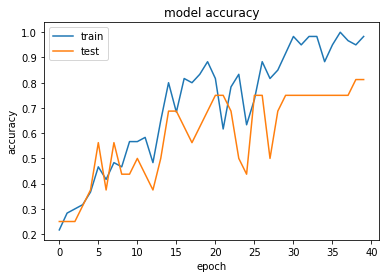

In [34]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

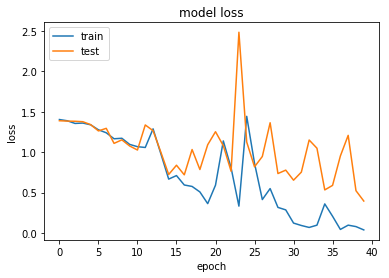

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
#Predict one image
checkImage = valid_images[14:15]
checklabel = valid_labels[14:15]
#print('checkImage:',checkImage)
predicts = model.predict(checkImage)
print("predicts:",predicts)
print("checklabel:",checklabel)

predicts: [[5.6636189e-03 9.5115846e-01 4.3177962e-02 2.0053310e-08]]
checklabel: [[0. 1. 0. 0.]]


In [37]:
# This function predicts an image according to the index of the valid_images array


def index_predict(n):
    checkImage = valid_images[n:n+1]
    checklabel = valid_labels[n:n+1]
    #print('checkImage:',checkImage)
    predicts = model.predict(checkImage)
    print("predicts:",predicts)

    print("Actual binary, name: ",checklabel[0], output[int(np.argmax(checklabel[0]))])
    for i in range(len(predicts)):
        print("Predicted :- ",output[int(np.argmax(predicts[i]))])
        #print('predict:',predict[i])

In [39]:
# Testing predictions and compare to actual label. We see some wrong predictions
for i in range(len(valid_labels)):
    index_predict(i)

predicts: [[9.9967408e-01 3.1478811e-04 1.1156099e-05 8.1213047e-10]]
Actual binary, name:  [1. 0. 0. 0.] caojun
Predicted :-  caojun
predicts: [[9.9998891e-01 6.5619579e-11 1.1069073e-05 6.3530112e-11]]
Actual binary, name:  [1. 0. 0. 0.] caojun
Predicted :-  caojun
predicts: [[4.8477512e-05 8.1345142e-04 4.3341255e-01 5.6572551e-01]]
Actual binary, name:  [0. 0. 0. 1.] mengziyi
Predicted :-  mengziyi
predicts: [[9.9848264e-01 9.1298636e-05 1.4259367e-03 1.2457194e-07]]
Actual binary, name:  [1. 0. 0. 0.] caojun
Predicted :-  caojun
predicts: [[2.7529502e-03 1.6037500e-06 9.9720144e-01 4.3987780e-05]]
Actual binary, name:  [0. 0. 1. 0.] gujiacheng
Predicted :-  gujiacheng
predicts: [[6.1711210e-01 6.2424760e-07 3.8280237e-01 8.4942614e-05]]
Actual binary, name:  [1. 0. 0. 0.] caojun
Predicted :-  caojun
predicts: [[1.9979581e-02 3.1624138e-06 9.4664109e-01 3.3376191e-02]]
Actual binary, name:  [0. 0. 1. 0.] gujiacheng
Predicted :-  gujiacheng
predicts: [[0.13610862 0.75189435 0.085853

In [40]:
for i in range(len(valid_labels)):
    print('i, valid_labels[i]:',i,valid_labels[i] )
#plt.imshow(valid_images[20])

i, valid_labels[i]: 0 [1. 0. 0. 0.]
i, valid_labels[i]: 1 [1. 0. 0. 0.]
i, valid_labels[i]: 2 [0. 0. 0. 1.]
i, valid_labels[i]: 3 [1. 0. 0. 0.]
i, valid_labels[i]: 4 [0. 0. 1. 0.]
i, valid_labels[i]: 5 [1. 0. 0. 0.]
i, valid_labels[i]: 6 [0. 0. 1. 0.]
i, valid_labels[i]: 7 [1. 0. 0. 0.]
i, valid_labels[i]: 8 [0. 0. 1. 0.]
i, valid_labels[i]: 9 [0. 0. 0. 1.]
i, valid_labels[i]: 10 [0. 0. 0. 1.]
i, valid_labels[i]: 11 [0. 0. 1. 0.]
i, valid_labels[i]: 12 [1. 0. 0. 0.]
i, valid_labels[i]: 13 [0. 1. 0. 0.]
i, valid_labels[i]: 14 [0. 1. 0. 0.]
i, valid_labels[i]: 15 [0. 1. 0. 0.]
